## Manually colapse the events in images 

Collapse the events in the frames to get the most active pixels and get an 'artificial brightnest' of the image 


In [2]:
# Get system path 
import os
path = os.getcwd()
# Get parent directory
parent = os.path.dirname(path)
#Add parent directory to system path
os.sys.path.insert(0, parent)

from metavision_core.event_io import EventsIterator
import numpy as np
import matplotlib.pyplot as plt

from lib.utils import *
from lib.plot_utils import *   
from lib.event_processing import *

from metavision_core.event_io import EventsIterator
from metavision_sdk_core import PeriodicFrameGenerationAlgorithm
from metavision_sdk_ui import EventLoop, BaseWindow, Window, UIAction, UIKeyEvent

import cv2

In [3]:
#Dynamicaly reload modules in juptyer notebook
%load_ext autoreload 
%autoreload 2

In [4]:
path = "../data/recordings/02_02/recording_2024-02-02_17-21-24_FOV14.3_MAG6.raw"
mv_iterator = EventsIterator(input_path=path, delta_t=1000)

height, width = mv_iterator.get_size()  # Camera Geometry
event_frame_gen = PeriodicFrameGenerationAlgorithm(width, height, accumulation_time_us=50000)

frames = []

def on_cd_frame_cb(ts, cd_frame):
    # window.show(cd_frame)
    frames.append(cd_frame)


event_frame_gen.set_output_callback(on_cd_frame_cb)

for evs in mv_iterator:
    event_frame_gen.process_events(evs)

print(len(frames))


229


In [5]:
#Plot one frame as an example 

# img = np.array(frames[4])
# # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# # print images
# cv2.imshow('image',gray)  
# cv2.waitKey() # This is necessary to be required so that the image doesn't close immediately.   
# cv2.destroyAllWindows() 

In [6]:
# Compact the frames

max_buffer = 10
blend = np.array(np.zeros((cv2.cvtColor(np.array(frames[0]), cv2.COLOR_BGR2GRAY).shape)))
copact_frames = []
count = 0
frames_buffer = []


for frame in frames:
    frames_buffer.append(frame)

    if len(frames_buffer) == max_buffer:
        blend = blend_buffer(frames_buffer, mirror=True)
        copact_frames.append(blend.astype(np.uint8))
        frames_buffer = []

print(len(copact_frames))

22


In [7]:
# Watch the compacted frames (OPTIONAL)

# for frame in copact_frames:
#     dst = cv2.fastNlMeansDenoising(frame)
#     cv2.imshow('press q to quit', dst)  
#     key = cv2.waitKey() # This is necessary to be required so that the image doesn't close immediately.   
    
#     if key == ord('q'):
#             cv2.destroyAllWindows()
#             break
    
#     cv2.destroyAllWindows()

In [8]:
# Check different filters (OPTIONAL)

# frame = copact_frames[5]
# frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)
# plot_image(np.array(frame))

# # plot_image(np.array(cv2.fastNlMeansDenoising(copact_frames[5])))
# frame = cv2.blur(frame,(3,3))
# print('max value: ', np.max(frame)), print('min value: ', np.min(frame))
# plot_image(np.array(frame))

# #Transform image to 0 255 range
# frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)
# plot_image(np.array(frame))

# frame = cv2.threshold(frame, 100, 1, cv2.THRESH_TOZERO)[1]
# plot_image(np.array(frame))


In [9]:
from lib.utils import *
from lib.event_processing import *

treshold = 0.2 # Percetange of max value 

filtered_frames = []
clusters_list = []
pixel_range = 15

for index, frame in  enumerate(copact_frames) :

    frame = cv2.blur(frame,(3,3))
    frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)

    max_val = np.max(frame)
    frame_thr = cv2.threshold(frame, max_val*treshold, 1, cv2.THRESH_TOZERO)[1]
    filtered_frames.append(frame_thr)
    
    clusters =  max_value_cluster(frame_thr, pixel_range, 30)
    clusters = sorted(clusters, key=lambda x: x[1], reverse=True)
    clusters_index = np.array([cluster[0] for cluster in clusters])
    clusters_index = sorted(clusters_index, key=lambda x: x[1], reverse=True)
    clusters_list.append( index_cluster(frame, pixel_range, clusters_index) )

    # print('Frame: ', index ,' Original clusters: ', len(clusters_index))


Original clusters:  27 Fitered clusters:  27


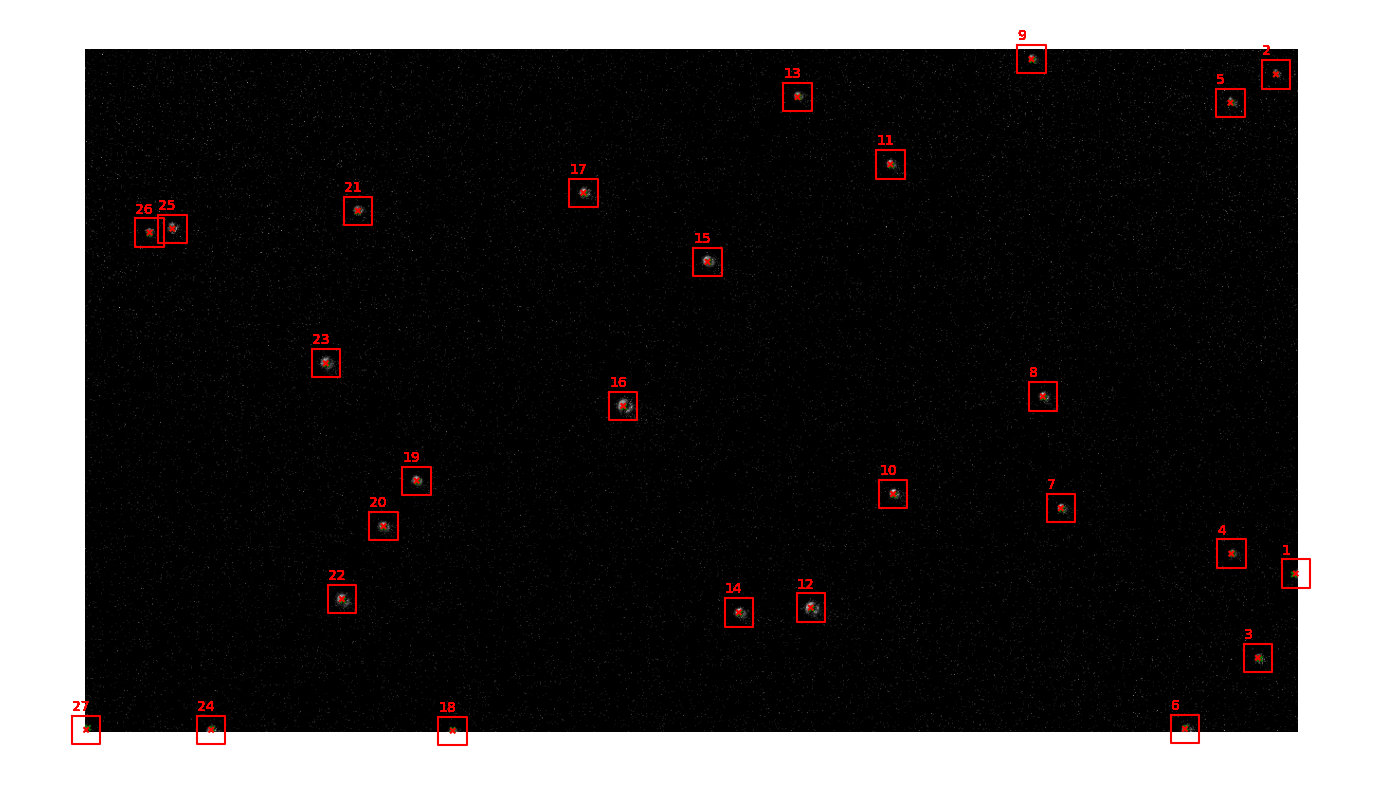

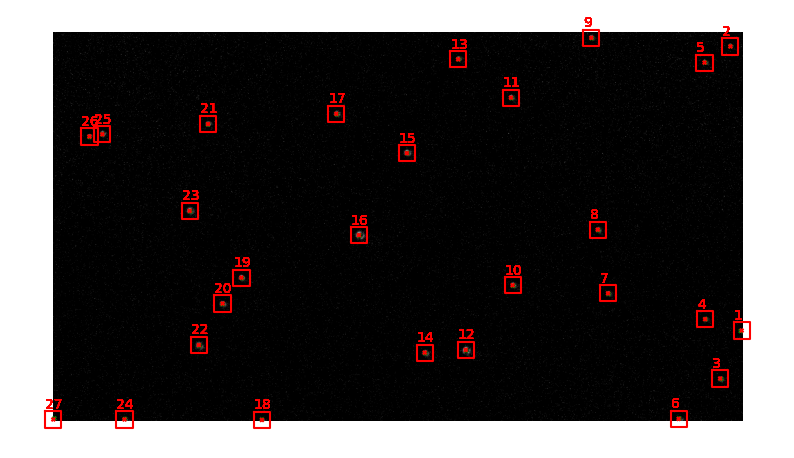

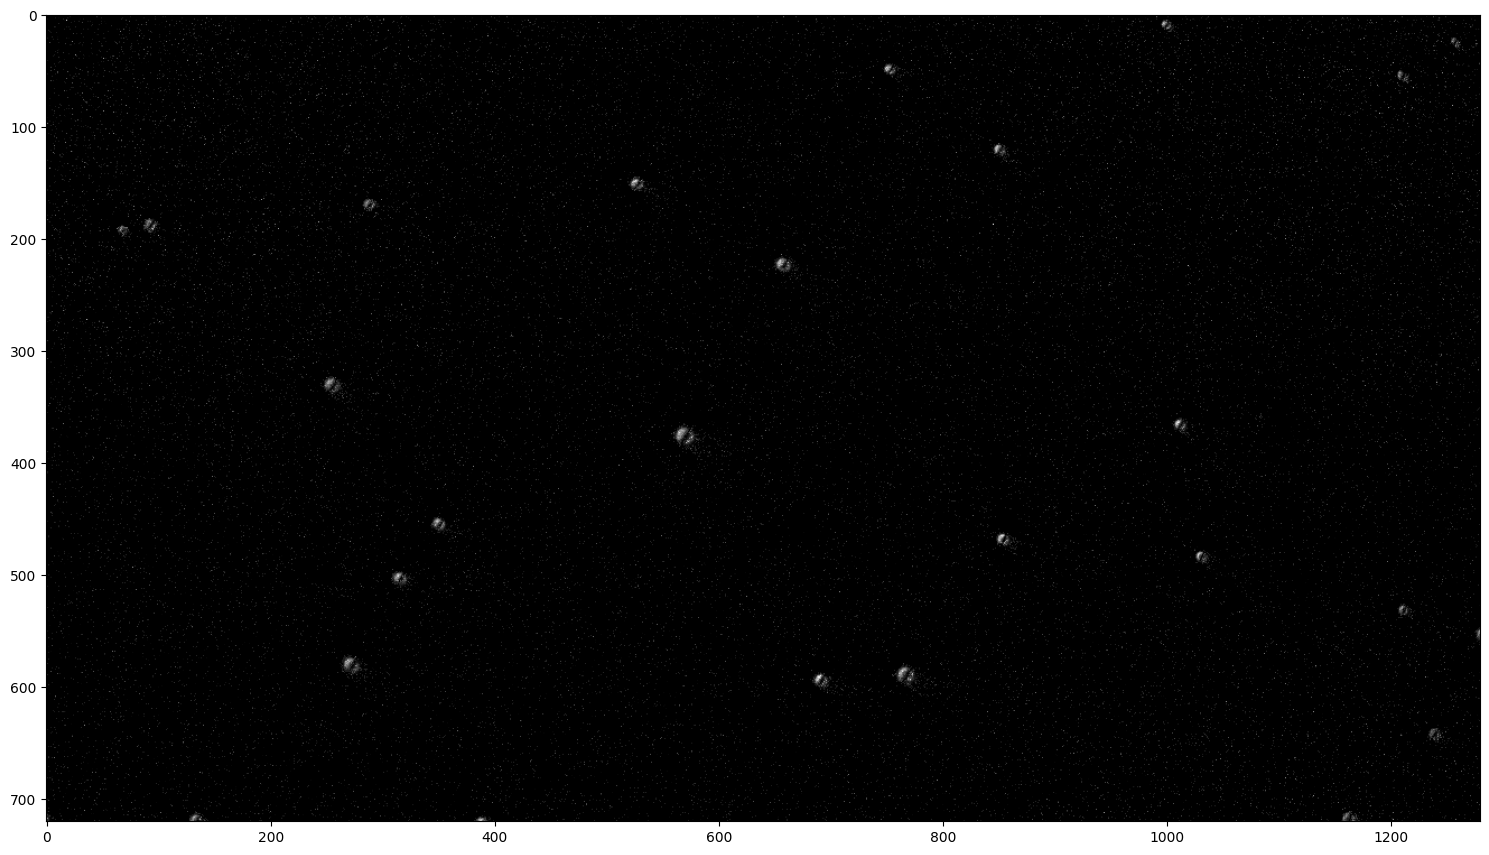

In [10]:
# FOR NOISY IMAGES delete the clusters with a mass lower than a treshold
mass_treshold = 0.0
treshold_val = mass_treshold*np.max([cluster_mass[1] for cluster_mass in  clusters_list[12]])
clusters_list_filtered = [cluster for cluster in clusters_list[12] if cluster[1] > treshold_val ]

print('Original clusters: ', len(clusters_list[12]),'Fitered clusters: ',  len(clusters_list_filtered))


#JUST TO CHECK SOM WITHOUT FALSE STARS
# clusters_list_filtered.pop(2) # Remove the cluster 3 of the frame 12
# clusters_list_filtered.pop(5) # Remove the cluster 7(-1) of the frame 12

plot_cluster(copact_frames[12], clusters_list_filtered, pixel_range, [18.5,10])
plot_cluster(copact_frames[12],clusters_list[12], pixel_range)

plot_image(copact_frames[12])
# plot_cluster(treshold_filter(frames[11], treshold ), clusters, 40)
#remove the position 4 of the clusters list


## GET STAR FEATURES AND STAR CENTROID 

Image center:  [360.  640.    1.5]
Order by distance to the center of the image
Cluster 1 [array([376, 569]), 24060]: distance to center: 72.78049189171504
Cluster 2 [array([223, 658]), 17012]: distance to center: 138.1774221788784
Cluster 3 [array([151, 527]), 13058]: distance to center: 237.59208741033444
Cluster 4 [array([594, 691]), 14561]: distance to center: 239.49321493520438
Cluster 5 [array([469, 854]), 13170]: distance to center: 240.160363090998
Cluster 6 [array([589, 767]), 20506]: distance to center: 261.8587405453559
Cluster 7 [array([455, 351]), 12692]: distance to center: 304.2137406495637
Cluster 8 [array([121, 851]), 11347]: distance to center: 318.8134250623709
Cluster 9 [array([ 49, 753]), 10539]: distance to center: 330.89273186336385
Cluster 10 [array([503, 315]), 13548]: distance to center: 355.0690073774392
Cluster 11 [array([ 366, 1012]), 11439]: distance to center: 372.0483839502599
Cluster 12 [array([331, 255]), 16073]: distance to center: 386.0906629277636
C

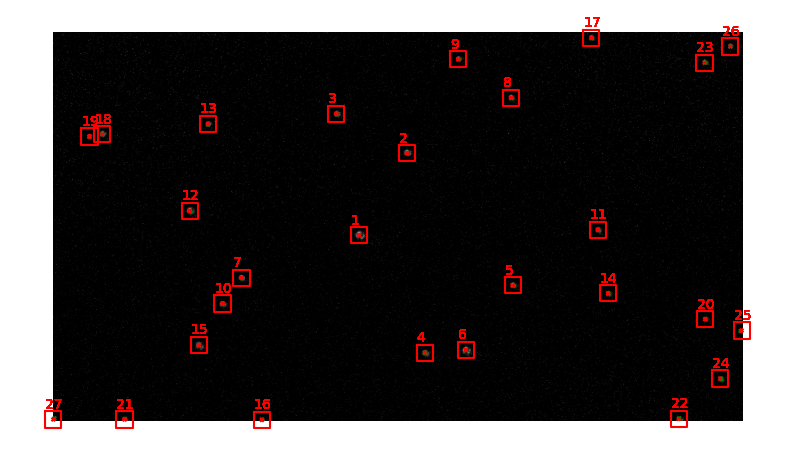

In [11]:
# Pop last value of each cluster (Previous cluster position)
# if len(clusters[0]) == 3:
    # [cluster.pop() for cluster in clusters]


clusters = clusters_list_filtered
# Get the clusters that are closest to the center of the image
clusters_sort, clusters_dist= order_by_center_dist([cluster for cluster in clusters ], copact_frames[12].shape)

print('Image center: ', np.array(frames[11].shape)/2)
print('Order by distance to the center of the image')
for i in range(len(clusters_sort)):
    print(f"Cluster {i+1} {clusters_sort[i][:2]}: distance to center: {clusters_dist[i]}")
# Plot the clusters on the image.

plot_cluster(copact_frames[12], clusters_sort, pixel_range)


In [12]:
# from lib.event_processing import *
# test_get_features()

Features 1 len:  8 , Features 2 len:  10
Main star:  [0.36101333 0.54632071]
Star 1: [0.21411163 0.63177333] 
Star 2: [0.14498142 0.50599475] 
Star 3: [0.43686454 0.33700979] 
Star 4: [0.57032426 0.66345801] 
[0.8879957  0.         1.14505597 0.71139724 1.158019   2.44531639
 1.23255438 4.17865601]
[2.43025381 3.14261724 3.18362026 3.42997984 2.05239815 5.28334988
 5.11395177 4.82297417 6.48582184 5.04325828]


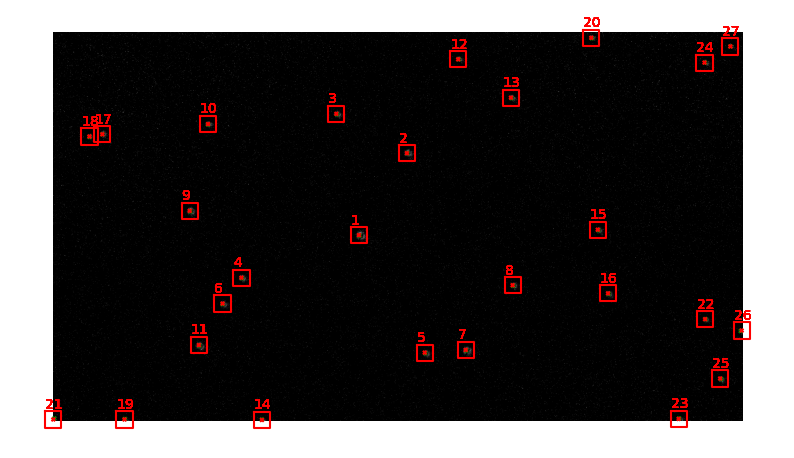

    recno  TYC1  TYC2  TYC3  BTmag  VTmag      HIP   RA(ICRS)  DE(ICRS)
0    9734    58  1618     1  4.687  2.716  14135.0  45.569912  4.089921
1    9659    58   607     1  5.487  5.591  14143.0  45.593785  4.352873
2   10433    62  1579     1  6.849  5.680  14915.0  48.109873  6.660885
3  134397   641   985     1  4.567  4.681  13954.0  44.928738  8.907399
4  135691   650  1471     1  4.721  3.705  15900.0  51.203480  9.029056
     recno  TYC1  TYC2  TYC3  BTmag  VTmag      HIP   RA(ICRS)   DE(ICRS)
12  134673   643   937     1  4.635  4.305  12828.0  41.234935  10.114216


In [13]:
# Get the features of the selected main star 
from lib.event_processing import *

main_star = clusters_sort[0]
stars_sorted_by_main = order_by_main_dist(main_star, clusters_sort)


# ref_pixel_to_deg = 0.005319449742301844 /3.5#In degres from sun_calibration with FOV=reference_FOV
ref_pixel_to_deg = 0.0009601418439716312

reference_FOV = 1 #In degrees
recording_FOV = 14.3 #In degrees

num_of_neirbours = 4
stars_features_1, stars_features_2 = get_star_features([star[0] for star in 
        stars_sorted_by_main[0:num_of_neirbours+1]], ref_pixel_to_deg, reference_FOV, recording_FOV)

print('Features 1 len: ',len(stars_features_1), ', Features 2 len: ', len(stars_features_2))
print('Main star: ', clusters_sort[0][0] * ref_pixel_to_deg * reference_FOV)
for i in range(1,5): 
    print(f"Star {i}: {stars_sorted_by_main[i][0] * ref_pixel_to_deg * reference_FOV} ")
print(stars_features_1)
print(stars_features_2)

plot_cluster(copact_frames[11], stars_sorted_by_main, pixel_range)


features_vec_1 = []
features_vec_2 = []

for main_star in clusters_sort:
    stars_sorted_by_main = order_by_main_dist(main_star, clusters_sort)
    stars_features_1, stars_features_2 = get_star_features([star[0] for star in stars_sorted_by_main[0:num_of_neirbours+1]])

    features_vec_1.append(stars_features_1)
    features_vec_2.append(stars_features_2)


# Plot the star info from the catalog 

stars_data = get_star_dataset(type ='tycho', path = '../data/catalogs/tycho2_VT_6.csv')
print(stars_data.head())
print(stars_data[stars_data['HIP'] == 12828])

if isinstance(stars_data, pd.DataFrame):
    # stars_data['data_number'] = stars_data.index
    stars_data = stars_data[['HIP','RA(ICRS)', 'DE(ICRS)']].values
 
stars_subset = [12706, 11738, 10723, 11687, 11021, 12387]
stars_subdata = stars_data[np.where(np.isin(stars_data[:,0], stars_subset))]
    


ange1:  0.9868603995109296 angle2:  1.2440389868510633 diference -0.25717858734013366
features 1  (array([0.8466168 , 0.        , 1.10367707, 0.71139724, 1.11664011,
       2.4453164 , 1.19117552, 4.17865596]), array([2.33174472, 3.01523288, 3.05457392, 3.29094751, 1.96920526,
       5.06919209, 4.90666057, 4.62747747, 6.22292257, 4.83883245]))
features 2  (array([0.8466168 , 0.        , 1.1392641 , 0.72944118, 1.15362237,
       2.42416965, 1.35736684, 4.3986203 ]), array([2.33174472, 3.12446822, 3.16965381, 3.88594749, 2.08231285,
       5.15962656, 5.11184098, 4.71777996, 6.77082228, 5.90111514]))


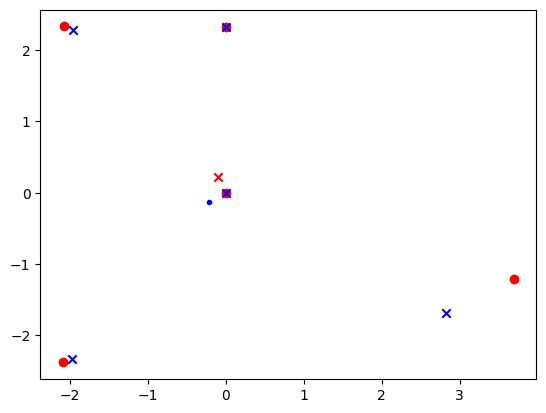

In [15]:
from lib.event_processing import *
pos = [[0.36101333, 0.54632071],
        [0.21411163,0.63177333],
        [0.14498142, 0.50599475],
        [0.43686454 ,0.33700979],
        [0.57032426, 0.66345801] ] 

pos_2 = [[41.234935, 10.114216],
        [41.239628, 12.445956],
        [39.157316, 12.447840],
        [39.146259, 7.730073],
        [44.928738, 8.907399] ]
print('ange1: ', np.arctan2(pos[0][1], pos[0][0]), 'angle2: ', np.arctan2(pos[1][1], pos[1][0]), 'diference' , np.arctan2(pos[0][1], pos[0][0]) - np.arctan2(pos[1][1], pos[1][0]) )

figure, ax = plt.subplots()
#Rescale the position to the main star to the center 

pos = np.array(pos) - pos[0]
pos_2= np.array(pos_2) - pos_2[0]

fac = np.linalg.norm(pos_2[1]  ) / np.linalg.norm(pos[1] )
pos = np.array(pos) * fac
center = np.mean(pos, axis=0)
center_2 = np.mean(pos_2, axis=0)

#ROtate 
alpha = -60
alpha = alpha*np.pi/180
R = np.array([[np.cos(alpha), -np.sin(alpha)],
        [np.sin(alpha), np.cos(alpha)]])
pos_rot = np.dot(R, pos.T).T

ax.scatter([x[0] for x in pos_2], [x[1] for x in pos_2], color='r', label='From dataset')
ax.scatter([x[0] for x in pos_rot], [x[1] for x in pos_rot], color='b', label='From recording', marker='x')
ax.scatter(center[0], center[1], color='b', label='Center', marker='.')
ax.scatter(center_2[0], center_2[1], color='r', label='Center', marker='x')


# Get features
print( 'features 1 ', get_star_features(np.array(pos), 1, 1, 1) )
print( 'features 2 ', get_star_features(np.array(pos_2), 1, 1, 1) )

In [40]:
import numpy as np
def test_get_features_2(): 
    '''
    Test the get features function
    
    '''
    #Rotation matrix
    # alpha = 0.1

    # R = np.array([[np.cos(alpha), -np.sin(alpha)],
    #                 [np.sin(alpha), np.cos(alpha)]])

    trans = 45
    test_stars =[ [45.569912 , 4.089921],
                [45.593785 , 4.352873],
                [48.109873 , 6.660885],
                [49.839787 , 3.369980],
                [50.278217 , 3.675680]] 
    test_stars * trans
    test_stars = np.array(test_stars)

    test_sol_1 = [-1.33168062, 1.28482521, 1.46560083, 1.55318345, 1.22798001, 1.47207766, 1.55458617, 1.31315452, 1.30551857, -0.6264524]
    test_sol_2 = [0.2640331480554887, 3.6140362126900363, 4.330144122389013, 4.726492802567647, 3.4143256508227946, 4.358280776498913, 4.733127431736677, 3.717883378629331, 3.6896019300520404, 0.5344845768068048]
    features_1, features_2 = get_star_features(test_stars,1,1,1)


    print('Features 1 len: ',len(features_1), ', Features 2 len: ', len(features_2))
    print('Main star: ', test_stars[0]) 
    print('Features 1: ', features_1)
    print('Features 2: ', features_2)
    print('Test sol 1: ', test_sol_1)

    for alpha in range(0, 1, 100):
        alpha = alpha*np.pi/180
        R = np.array([[np.cos(alpha), -np.sin(alpha)],
                    [np.sin(alpha), np.cos(alpha)]])
        test_stars_rot = np.dot(R, test_stars.T).T
        features_1, features_2 = get_star_features(test_stars_rot,1,1,1)

        features_1[::2] += np.log(trans)
        error1 = test_sol_1 - features_1
        if np.max(error1) > 0.001:
            print('alpha: ', alpha*180/np.pi)
            print('Features 1: ', features_1)
            print('Features 1 sol: ', test_sol_1)
            print('Error 1: ', error1)


    # print('Test error 1:', np.array(test_sol_1) - np.array(features_1))
    # print('Test error 2:', np.array(test_sol_2) - np.array(features_2))

test_get_features_2()

Features 1 len:  10 , Features 2 len:  10
Main star:  [45.569912  4.089921]
Features 1:  [-1.3316794   1.28482521  1.46560081  1.55318339  1.22797995  1.47207767
  1.55458614  1.31315457  1.30551865 -0.62645312]
Features 2:  [0.26403347 3.61403622 4.33014406 4.72649252 3.41432544 4.35828081
 4.73312725 3.71788356 3.68960223 0.5344842 ]
Test sol 1:  [-1.33168062, 1.28482521, 1.46560083, 1.55318345, 1.22798001, 1.47207766, 1.55458617, 1.31315452, 1.30551857, -0.6264524]


In [50]:
import minisom 
import pickle

mesh_size = 67
catalog_filter = 6

name = 'n'+ str(mesh_size) +'_tycho' + str(catalog_filter)


#Load som from previusly trained model
with open('../data/SOM_parameters/'+name+'/som1_'+ name + '.p', 'rb') as infile:
    som1, som2 = pickle.load(infile)

#Load normalization parameters
with open('../data/SOM_parameters/'+name+'/normalization_parameters_tycho' + str(catalog_filter) + '.p', 'rb') as infile:
    norm_param = pickle.load(infile)

#Load dictionary with the star features
with open('../data/SOM_parameters/'+name+'/star_dict_'+ name + '.p', 'rb') as infile:
    star_dict_1, star_dict_2 = pickle.load(infile)

In [51]:
#Get the image postion
from lib.event_processing import *

# ref_pixel_to_deg = 0.005319449742301844 /3.5#In degres from sun_calibration with FOV=reference_FOV
ref_pixel_to_deg = 0.0009601418439716312 #In degres from sun_calibration with FOV=reference_FOV

stars_data = get_star_dataset(type ='tycho', path = '../data/catalogs/tycho2_VT_6.csv')
if isinstance(stars_data, pd.DataFrame):
    # stars_data['data_number'] = stars_data.index
    stars_data = stars_data[['HIP','RA(ICRS)', 'DE(ICRS)']].values

reference_FOV = 1 #In degrees
recording_FOV = 14.3 #In degrees
num_of_neirbours = 4

features_vec_1 = []
features_vec_2 = []

predcited_stars = []

for main_star in clusters_sort:
    stars_sorted_by_main = order_by_main_dist(main_star, clusters_sort)

    stars_features_1, stars_features_2 = get_star_features([star[0] for star in 
            stars_sorted_by_main[0:num_of_neirbours+1]], ref_pixel_to_deg, reference_FOV, recording_FOV)

    features_vec_1.append(stars_features_1)
    features_vec_2.append(stars_features_2)

    # Get prediction index
    predicted_star_ids_1 = predict_star_id(stars_features_1, norm_param[0:2], star_dict_1, som1)
    predicted_star_ids_2 = predict_star_id(stars_features_2, norm_param[2:4], star_dict_2, som2)
    # Get HIP of index
    hip_ids_predicted_1 = [stars_data[x][0].astype(int) for x in predicted_star_ids_1]
    hip_ids_predicted_2 = [stars_data[x][0].astype(int) for x in predicted_star_ids_2]

    # Get the intersection of the two predictions if there is only one star in common
    if len(list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))) < 2 and len(
        list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))) > 0:
        star_guess = list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))[0]
    else:
        star_guess = None

    predcited_stars.append([hip_ids_predicted_1, hip_ids_predicted_2, star_guess])

for i in range(len(predcited_stars)):
    print('Main star: ', clusters_sort[i][:2])
    print('Predicted star ids 1: ', predcited_stars[i][0])
    print('Predicted star ids 2: ', predcited_stars[i][1])
    print('Predicted star id: ', predcited_stars[i][2])
    print(stars_data[predcited_stars[i][2]] if predcited_stars[i][2] is not None else 'No star found')


print([x[2] for x in predcited_stars])

Main star:  [array([376, 569]), 24060]
Predicted star ids 1:  [12828, 13775, 46026]
Predicted star ids 2:  [12828, 102831]
Predicted star id:  12
[1.28280000e+04 4.12349347e+01 1.01142161e+01]
Main star:  [array([223, 658]), 17012]
Predicted star ids 1:  [12832]
Predicted star ids 2:  [12832]
Predicted star id:  15
[1.28320000e+04 4.12396281e+01 1.24459558e+01]
Main star:  [array([151, 527]), 13058]
Predicted star ids 1:  [12153, 3231, 84248]
Predicted star ids 2:  [12153]
Predicted star id:  16
[12153.            39.15731611    12.44783972]
Main star:  [array([594, 691]), 14561]
Predicted star ids 1:  [103401]
Predicted star ids 2:  [56445]
Predicted star id:  None
No star found
Main star:  [array([469, 854]), 13170]
Predicted star ids 1:  [14354, 55650]
Predicted star ids 2:  [70497]
Predicted star id:  None
No star found
Main star:  [array([589, 767]), 20506]
Predicted star ids 1:  [29941]
Predicted star ids 2:  [61015]
Predicted star id:  None
No star found
Main star:  [array([455,

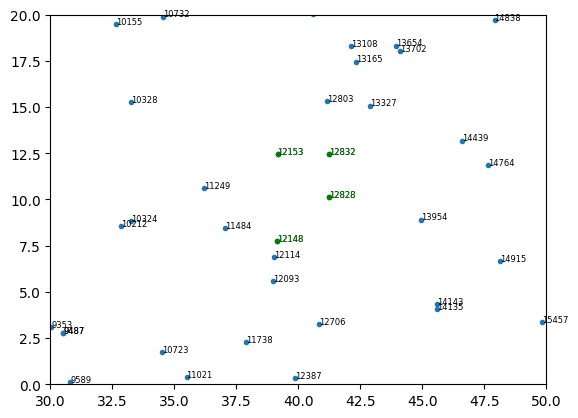

/tmp/ipykernel_3916/3433596434.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_cluster_with_id(copact_frames[11], np.array(clusters_sort)[:,0], ids)


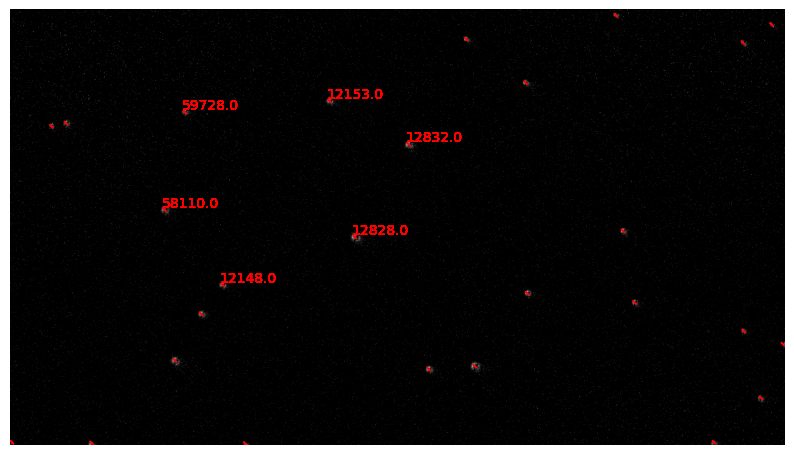

In [52]:
from lib.plot_utils import *
plt.figure()

x_range = [30, 50]
y_range = [0, 20]

#Plot the identification names of the set of stars in the range of the image
plt.plot([x[1] for x in stars_data],stars_data[:,2],'.')

# plt.plot([x[1] for x in stars_data],stars_data[:,2],'.')
# #Plot the identification names of the set of stars
for i in range(len(stars_data)):
    if stars_data[i,1] < x_range[1] and stars_data[i,1] > x_range[0] and stars_data[i,2] < y_range[1] and stars_data[i,2] > y_range[0]:
        plt.text(stars_data[i,1], stars_data[i,2], str(int(stars_data[i,0])) , fontsize=6)

x_range = [30, 50]
y_range = [0, 20]

not_none = [x[2] for x in predcited_stars if x[2] is not None]
stars_subdata = stars_data[not_none]
#Check that the stars are in range 
# stars_subdata = [x.tolist() for x in stars_subdata if np.round(x[1]) in range(x_range[0], x_range[1]) and np.round(x[2]) in range(y_range[0], y_range[1])]

plt.plot([x[1] for x in stars_subdata],stars_subdata[:,2],'.g')
#Plot the identification names of the sub set of stars
for i in range(len(stars_subdata)):
    if stars_subdata[i,1] < x_range[1] and stars_subdata[i,1] > x_range[0] and stars_subdata[i,2] < y_range[1] and stars_subdata[i,2] > y_range[0]:
        plt.text(stars_subdata[i,1], stars_subdata[i,2], str(int(stars_subdata[i,0])) , fontsize=6, color = 'g')

#change the limits of the axis
plt.xlim(x_range)
plt.ylim(y_range)

plt.show()  

ids = []
for x in predcited_stars:
    ids.append(stars_data[x[2]][0] if x[2] is not None else None)


plot_cluster_with_id(copact_frames[11], np.array(clusters_sort)[:,0], ids)

In [ ]:
star_postion = np.array([60,80]) #EXAMPLE -> GET FROM SOM

img_center = np.array(copact_frames[11].shape)/2


print('Main star: ', main_star[0])
distance_to_center = main_star[0] - img_center
print('Pixel distance to center: ', distance_to_center)
print('Distance to center: ', distance_to_center*pixel_to_deg)
print('Camera position: ', star_postion + distance_to_center*pixel_to_deg)